In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
def g(x, a=1., mu=0., s=1.):
    return a*np.exp(-(x-mu)**2/s**2)

def heaviside(x,a):
    ret = np.zeros_like(x)
    ret[x>a] = 1.
    return ret

def g1(x,a,b,c=1.):
    return c*(heaviside(x,a)-heaviside(x,b))

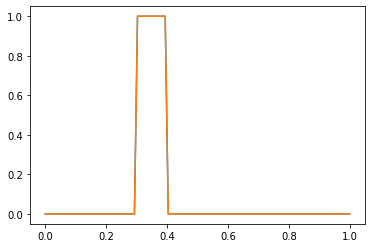

In [3]:
t = np.linspace(0,1,100)
h1 = heaviside(t,0.3)
h2 = heaviside(t,0.4)
plt.plot(t,h1-h2)
plt.plot(t,g1(t,0.3,0.4))

In [4]:
def p_noise(x,s=0.):
    return s*np.random.poisson(x)

def background(x,s=0.1):
    return s*np.random.poisson(np.ones_like(x))

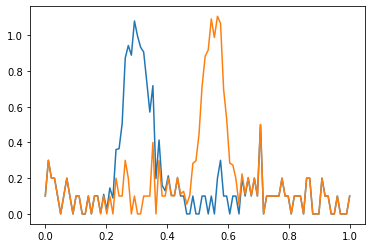

In [5]:
t = np.linspace(0,1.,100)
dt = t[1]-t[0]
shift = 0.25
bg = background(t)
lc1 = g(t,mu=0.3,s=0.05)
lcn1 = lc1 + p_noise(lc1) + bg
lc2 = g(t,mu=0.3+shift,s=0.05)
lcn2 = lc2 + p_noise(lc2) + bg
plt.plot(t,lcn1)
plt.plot(t,lcn2)

In [6]:
ccf = np.correlate(lcn1,lcn2, 'full')
ccf.shape

(199,)

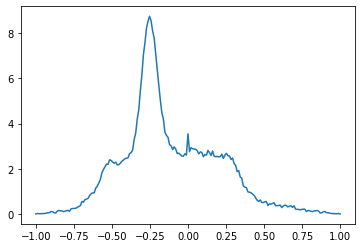

In [7]:
plt.plot(np.arange(len(ccf))*dt-1,ccf)

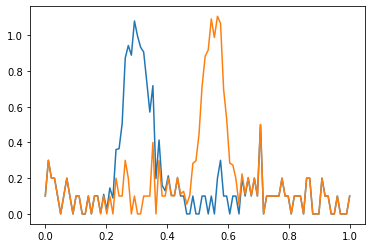

In [8]:
t = np.linspace(0,1.,100)
dt = t[1]-t[0]
shift = 0.25
lc1 = g(t,mu=0.3,s=0.05) #+ g(t,mu=0.5,s=0.15)
lcn1 = lc1 + p_noise(lc1, 0.0) + bg
lc2 = g(t,mu=0.3+shift,s=0.05) #+ g(t,mu=0.5+shift,s=0.15)
lcn2 = lc2 + p_noise(lc2, 0.0) + bg
plt.plot(t,lcn1)
plt.plot(t,lcn2)

In [9]:
ccf = np.correlate(lcn1,lcn2, 'full')
ccf.shape

(199,)

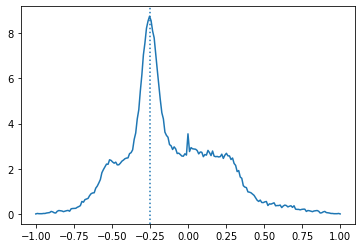

In [10]:
plt.plot(np.arange(len(ccf))*dt-1,ccf)
plt.axvline(-shift, linestyle=":")

In [11]:
from scipy.optimize import curve_fit

def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
x = np.arange(len(ccf))*dt-1
y = ccf
popt,pcov = curve_fit(gauss,x,y,p0=[1.,0.25,0.1])

In [12]:
popt

array([ 4.87251081, -0.1804285 ,  0.27941309])

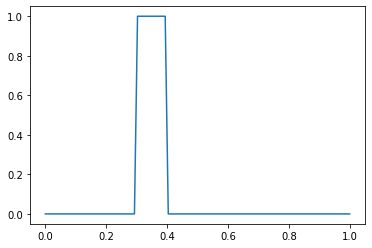

In [13]:
t = np.linspace(0,1.,100)
dt = t[1]-t[0]
shift = 0.25
lc1 = g1(t, 0.3, 0.4)
plt.plot(t,lc1)

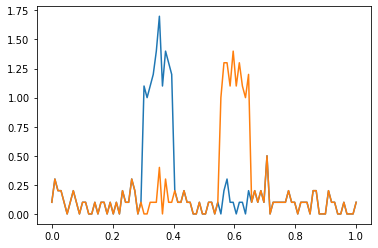

In [14]:
lcn1 = lc1 + p_noise(lc1,0.1) + bg
lc2 = g1(t ,0.3+shift, 0.4+shift) 
lcn2 = lc2 + p_noise(lc2,0.1) + bg
plt.plot(t,lcn1)
plt.plot(t,lcn2)

In [15]:
ccf = np.correlate(lcn1,lcn2, 'full')
ccf.shape

(199,)

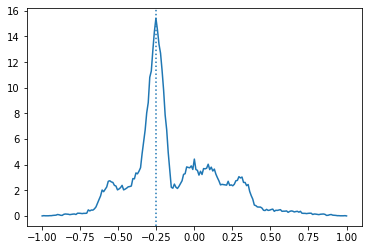

In [16]:
plt.plot(np.arange(len(ccf))*dt-1,ccf)
plt.axvline(-shift, linestyle=":")

In [17]:
def make_lc(times, dt, tstart=None, use_hist=False, reset_time=False):
    """
    """
    times = np.sort(np.asarray(times))
    if tstart is None:
        tstart = times[0]
    duration = times[-1] - tstart
    nbin = np.int64(duration / dt)
    tend = tstart + nbin * dt
    
    good = (tstart <= times) & (times < tend)
    
    if not use_hist:
        binned_times = ((times[good] - tstart) // dt).astype(np.int64)
        counts = np.bincount(binned_times, minlength=nbin)
        t = tstart + np.arange(0.5, 0.5 + len(counts)) * dt
    else:
        histbins = np.arange(tstart, tend + dt, dt)
        counts, histbins = np.histogram(times[good], bins=histbins)
        t = histbins[:-1] + 0.5 * dt

    if reset_time == True:
        t -= t[0]
    return t, counts

In [18]:
arrival_times = 100*np.random.random(1000)

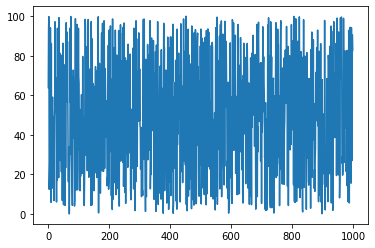

In [19]:
plt.plot(arrival_times)

In [20]:
t,c = make_lc(arrival_times,1.)

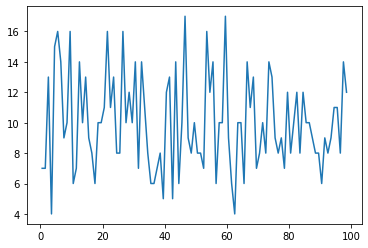

In [21]:
plt.plot(t,c)

In [22]:
# https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/bursts/2020/bn200224416/current/

def get_arrival_times_from_eventlist(bid="200412381", det=5):
    fn="https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/bursts/2020/bn%s/current/glg_tte_n%i_bn%s_v00.fit"
    eventlist=fits.getdata(fn%(bid,det,bid),ext=2)
    return eventlist['TIME']

In [24]:
arrival_times_det5=get_arrival_times_from_eventlist(det=5)
arrival_times_det3=get_arrival_times_from_eventlist(det=3)

In [25]:
t1,c1 = make_lc(arrival_times_det5, dt=1.)
t1 = t1-t1[0]
c1 = (c1-np.min(c1))/(np.max(c1)-np.min(c1))

In [26]:
t2, c2 = make_lc(arrival_times_det3, dt=1.)
t2 = t2-t2[0]
c2 = (c2-np.min(c2))/(np.max(c2)-np.min(c2))

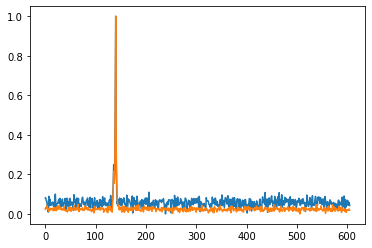

In [27]:
plt.plot(t1,c1)
plt.plot(t2,c2)

In [28]:
t

array([ 0.55358346,  1.55358346,  2.55358346,  3.55358346,  4.55358346,
        5.55358346,  6.55358346,  7.55358346,  8.55358346,  9.55358346,
       10.55358346, 11.55358346, 12.55358346, 13.55358346, 14.55358346,
       15.55358346, 16.55358346, 17.55358346, 18.55358346, 19.55358346,
       20.55358346, 21.55358346, 22.55358346, 23.55358346, 24.55358346,
       25.55358346, 26.55358346, 27.55358346, 28.55358346, 29.55358346,
       30.55358346, 31.55358346, 32.55358346, 33.55358346, 34.55358346,
       35.55358346, 36.55358346, 37.55358346, 38.55358346, 39.55358346,
       40.55358346, 41.55358346, 42.55358346, 43.55358346, 44.55358346,
       45.55358346, 46.55358346, 47.55358346, 48.55358346, 49.55358346,
       50.55358346, 51.55358346, 52.55358346, 53.55358346, 54.55358346,
       55.55358346, 56.55358346, 57.55358346, 58.55358346, 59.55358346,
       60.55358346, 61.55358346, 62.55358346, 63.55358346, 64.55358346,
       65.55358346, 66.55358346, 67.55358346, 68.55358346, 69.55

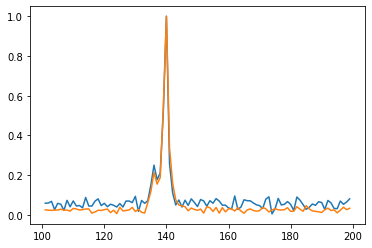

In [29]:
good = (t1>100) & (t1<200)
plt.plot(t1[good],c1[good])
plt.plot(t2[good],c2[good])

In [30]:
ccf = np.correlate(c1,c2, 'same')
ccf.shape

(606,)

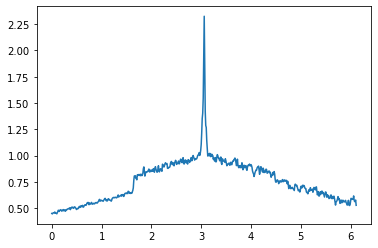

In [33]:
plt.plot(np.arange(len(ccf))*dt,ccf)

In [34]:
times = np.sort(np.asarray(arrival_times1))

In [ ]:
times

array([6.08375195e+08, 6.08375195e+08, 6.08375195e+08, ...,
       6.08375801e+08, 6.08375801e+08, 6.08375801e+08])